# Luxury Retail Customer Segmentation using K-Means

This project focuses on customer segmentation for a luxury retail context inspired by brands like Sephora, Dior, and Louis Vuitton.

The main goal is to group customers into meaningful segments based on their purchasing behavior, such as:

- High-spending luxury shoppers  
- Beauty-focused customers  
- Deal-sensitive buyers  
- Loyal repeat buyers  
- Occasional shoppers  

These segments can help the business design targeted marketing campaigns, loyalty programs, and personalized product recommendations.

## Dataset

In this project, we will work with a synthetic luxury retail dataset that contains fields like:

- Customer ID  
- Age  
- Gender  
- Country  
- Favorite Category (e.g., Makeup, Skincare, Fragrance, Handbags, Accessories)  
- Total Spending  
- Number of Purchases  
- Visit Frequency  
- Recency (days since last purchase)  
- Derived features such as:
  - Average Basket Size  
  - Annual Spending  
  - Normalized Spending  
  - Recency Score  

## Methodology

We will follow these main steps:

1. Generate and load the luxury retail dataset  
2. Perform Exploratory Data Analysis (EDA)  
3. Engineer features and preprocess the data  
4. Apply K-Means clustering  
5. Choose the number of clusters using the Elbow Method and Silhouette Score  
6. Visualize the customer segments  
7. Extract business insights from each cluster  



In [1]:
# STEP 1: Imports & Synthetic Luxury Retail Dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid")
np.random.seed(42)

# -----------------------------------
# 1.1 Generate synthetic luxury retail customers
# -----------------------------------

n_customers = 3000  # you can change this if you want

customer_id = np.arange(1, n_customers + 1)

# Age: centered around 35 with some variation
ages = np.random.normal(35, 10, n_customers)
ages = np.clip(ages, 18, 70).astype(int)

# Gender distribution
genders = np.random.choice(
    ["Male", "Female"],
    size=n_customers,
    p=[0.3, 0.7]
)

# Countries: mix of GCC + international luxury markets
countries = np.random.choice(
    [
        "Saudi Arabia",
        "United Arab Emirates",
        "Qatar",
        "Kuwait",
        "Bahrain",
        "France",
        "United Kingdom",
        "United States",
        "China",
    ],
    size=n_customers,
    p=[0.18, 0.18, 0.08, 0.08, 0.08, 0.12, 0.10, 0.10, 0.08],
)

# Favorite product category (Sephora / Dior / LV style)
favorite_categories = np.random.choice(
    ["Makeup", "Skincare", "Fragrance", "Handbags", "Accessories"],
    size=n_customers,
    p=[0.30, 0.25, 0.20, 0.15, 0.10],
)

# Base spending level by category (approx, in USD)
category_base_spend = {
    "Makeup": 800,
    "Skincare": 900,
    "Fragrance": 1000,
    "Handbags": 2500,
    "Accessories": 1500,
}

# Country multiplier (e.g., higher in Gulf / UAE)
country_multiplier = {
    "Saudi Arabia": 1.20,
    "United Arab Emirates": 1.30,
    "Qatar": 1.10,
    "Kuwait": 1.10,
    "Bahrain": 1.00,
    "France": 1.00,
    "United Kingdom": 0.95,
    "United States": 1.05,
    "China": 0.90,
}

cat_spend = np.array([category_base_spend[c] for c in favorite_categories])
country_mult = np.array([country_multiplier[c] for c in countries])

# Total spending in the last year
total_spending = np.random.normal(
    loc=cat_spend * country_mult,
    scale=cat_spend * 0.4
)
total_spending = np.clip(total_spending, 100, None)  # minimum 100

# Number of purchases per year (approx)
num_purchases = np.random.poisson(
    lam=(total_spending / 400).clip(1, 20)
)
num_purchases = np.clip(num_purchases, 1, None)

# Visit frequency (visits per month)
visit_frequency = np.random.poisson(
    lam=(num_purchases / 3).clip(1, 15)
)
visit_frequency = np.clip(visit_frequency, 1, None)

# Recency: days since last purchase
# Higher visit frequency -> usually lower recency
base_recency = np.random.exponential(scale=60, size=n_customers)
recency_days = base_recency / (visit_frequency / 2)
recency_days = np.clip(recency_days, 1, 365).astype(int)

# Average basket size
avg_basket_size = total_spending / num_purchases

# Annual spending (same as total_spending here)
annual_spending = total_spending

# Normalized spending 0–1
normalized_spending = (
    (total_spending - total_spending.min())
    / (total_spending.max() - total_spending.min())
)

# Recency score (1 = very recent, 0 = very old)
recency_score = 1 - (recency_days / recency_days.max())

# -----------------------------------
# 1.2 Build DataFrame
# -----------------------------------

df = pd.DataFrame(
    {
        "customer_id": customer_id,
        "age": ages,
        "gender": genders,
        "country": countries,
        "favorite_category": favorite_categories,
        "total_spending": total_spending.round(2),
        "num_purchases": num_purchases,
        "visit_frequency": visit_frequency,
        "recency_days": recency_days,
        "avg_basket_size": avg_basket_size.round(2),
        "annual_spending": annual_spending.round(2),
        "normalized_spending": normalized_spending,
        "recency_score": recency_score,
    }
)

# Quick look at the data
print("Shape:", df.shape)
df.head()


Shape: (3000, 13)


,customer_id,age,gender,country,favorite_category,total_spending,num_purchases,visit_frequency,recency_days,avg_basket_size,annual_spending,normalized_spending,recency_score
0,1,39,Female,United Arab Emirates,Makeup,950.01,4,1,131,237.50,950.01,0.151388,0.641096
1,2,33,Female,Kuwait,Fragrance,1149.37,1,1,63,1149.37,1149.37,0.186893,0.827397
2,3,41,Male,Qatar,Fragrance,1277.84,2,1,148,638.92,1277.84,0.209773,0.594521
3,4,50,Female,United Kingdom,Handbags,2808.84,7,1,35,401.26,2808.84,0.482444,0.904110
4,5,32,Female,United Kingdom,Fragrance,648.75,4,1,47,162.19,648.75,0.097733,0.871233


## Step 2 – Exploratory Data Analysis (EDA)

In this section, we explore the synthetic luxury retail dataset to understand the customers and their purchasing behavior.

We will look at:

- Basic structure of the dataset (rows, columns, data types)
- Summary statistics for numerical features (spending, purchases, recency, age)
- Distribution of key variables such as:
  - Total spending
  - Number of purchases
  - Visit frequency
  - Recency (days since last purchase)
- Category preferences:
  - Favorite product categories
  - Countries / regions of customers
- Correlations between numerical features to see which variables move together

This EDA step helps us understand the data before applying K-Means clustering and makes it easier to interpret the customer segments later.


In [2]:
# STEP 2: Exploratory Data Analysis (EDA)

# -----------------------------
# 2.1 Basic overview
# -----------------------------
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

print("\nFirst 5 rows:")
display(df.head())

print("\nSummary statistics (numerical):")
display(df.describe().T)

print("\nSummary (including categorical - top 15 rows):")
display(df.describe(include="all").T.head(15))

# Check missing values
print("\nMissing values per column:")
print(df.isnull().sum())




Dataset shape: (3000, 13)

Data types:
customer_id              int64
age                      int64
gender                  object
country                 object
favorite_category       object
total_spending         float64
num_purchases            int64
visit_frequency          int64
recency_days             int64
avg_basket_size        float64
annual_spending        float64
normalized_spending    float64
recency_score          float64
dtype: object

First 5 rows:


,customer_id,age,gender,country,favorite_category,total_spending,num_purchases,visit_frequency,recency_days,avg_basket_size,annual_spending,normalized_spending,recency_score
0,1,39,Female,United Arab Emirates,Makeup,950.01,4,1,131,237.50,950.01,0.151388,0.641096
1,2,33,Female,Kuwait,Fragrance,1149.37,1,1,63,1149.37,1149.37,0.186893,0.827397
2,3,41,Male,Qatar,Fragrance,1277.84,2,1,148,638.92,1277.84,0.209773,0.594521
3,4,50,Female,United Kingdom,Handbags,2808.84,7,1,35,401.26,2808.84,0.482444,0.904110
4,5,32,Female,United Kingdom,Fragrance,648.75,4,1,47,162.19,648.75,0.097733,0.871233



Summary statistics (numerical):


,count,mean,std,min,25%,50%,75%,max
customer_id,3000.0,1500.500000,866.169729,1.00,750.750000,1500.500000,2250.250000,3000.00000
age,3000.0,34.976333,9.494761,18.00,28.000000,35.000000,41.000000,70.00000
total_spending,3000.0,1325.312950,854.659037,100.00,798.187500,1092.700000,1553.642500,5714.82000
num_purchases,3000.0,3.453667,2.664374,1.00,1.000000,3.000000,5.000000,20.00000
visit_frequency,3000.0,1.672333,1.125784,1.00,1.000000,1.000000,2.000000,10.00000
recency_days,3000.0,88.723000,90.405453,1.00,21.000000,56.500000,126.000000,365.00000
avg_basket_size,3000.0,493.765983,306.096511,33.33,283.292500,403.565000,618.055000,2788.50000
annual_spending,3000.0,1325.312950,854.659037,100.00,798.187500,1092.700000,1553.642500,5714.82000
normalized_spending,3000.0,0.218228,0.152215,0.00,0.124347,0.176801,0.258893,1.00000
recency_score,3000.0,0.756923,0.247686,0.00,0.654795,0.845205,0.942466,0.99726



Summary (including categorical - top 15 rows):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,3000.0,NaN,NaN,NaN,1500.5,866.169729,1.0,750.75,1500.5,2250.25,3000.0
age,3000.0,NaN,NaN,NaN,34.976333,9.494761,18.0,28.0,35.0,41.0,70.0
gender,3000,2,Female,2095,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,3000,9,United Arab Emirates,562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
favorite_category,3000,5,Makeup,896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_spending,3000.0,NaN,NaN,NaN,1325.31295,854.659037,100.0,798.1875,1092.7,1553.6425,5714.82
num_purchases,3000.0,NaN,NaN,NaN,3.453667,2.664374,1.0,1.0,3.0,5.0,20.0
visit_frequency,3000.0,NaN,NaN,NaN,1.672333,1.125784,1.0,1.0,1.0,2.0,10.0
recency_days,3000.0,NaN,NaN,NaN,88.723,90.405453,1.0,21.0,56.5,126.0,365.0
avg_basket_size,3000.0,NaN,NaN,NaN,493.765983,306.096511,33.33,283.2925,403.565,618.055,2788.5



Missing values per column:
customer_id            0
age                    0
gender                 0
country                0
favorite_category      0
total_spending         0
num_purchases          0
visit_frequency        0
recency_days           0
avg_basket_size        0
annual_spending        0
normalized_spending    0
recency_score          0
dtype: int64



Favorite category counts:
favorite_category
Makeup         896
Skincare       729
Fragrance      589
Handbags       480
Accessories    306
Name: count, dtype: int64

Country counts:
country
United Arab Emirates    562
Saudi Arabia            537
France                  353
Kuwait                  285
United Kingdom          273
United States           268
Qatar                   260
Bahrain                 238
China                   224
Name: count, dtype: int64


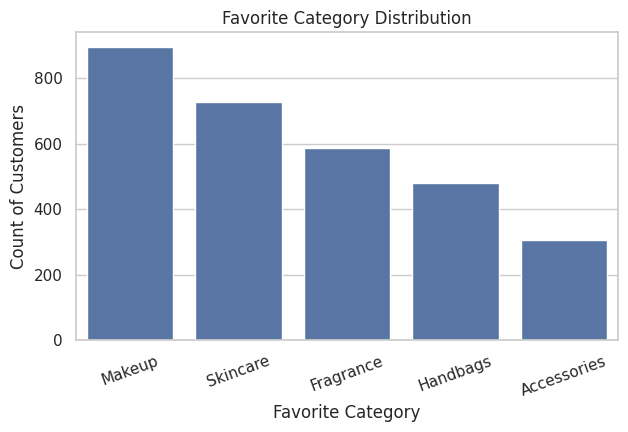

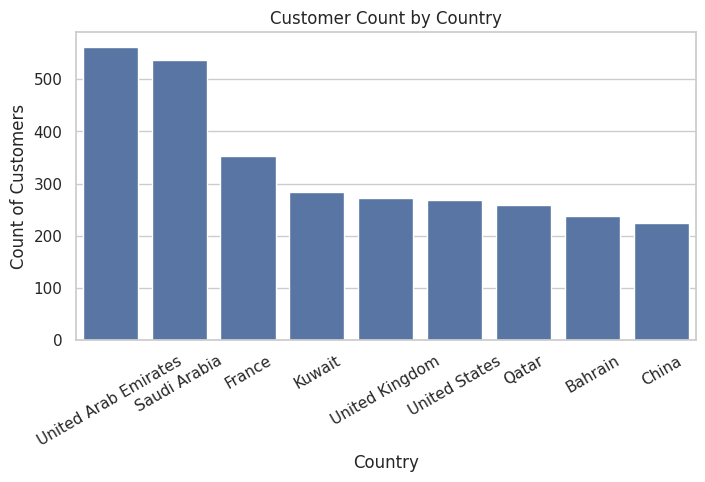

In [3]:
# 2.2 Category and country distributions
# -----------------------------
print("\nFavorite category counts:")
print(df["favorite_category"].value_counts())

print("\nCountry counts:")
print(df["country"].value_counts())

plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="favorite_category", order=df["favorite_category"].value_counts().index)
plt.title("Favorite Category Distribution")
plt.xlabel("Favorite Category")
plt.ylabel("Count of Customers")
plt.xticks(rotation=20)
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="country", order=df["country"].value_counts().index)
plt.title("Customer Count by Country")
plt.xlabel("Country")
plt.ylabel("Count of Customers")
plt.xticks(rotation=30)
plt.show()

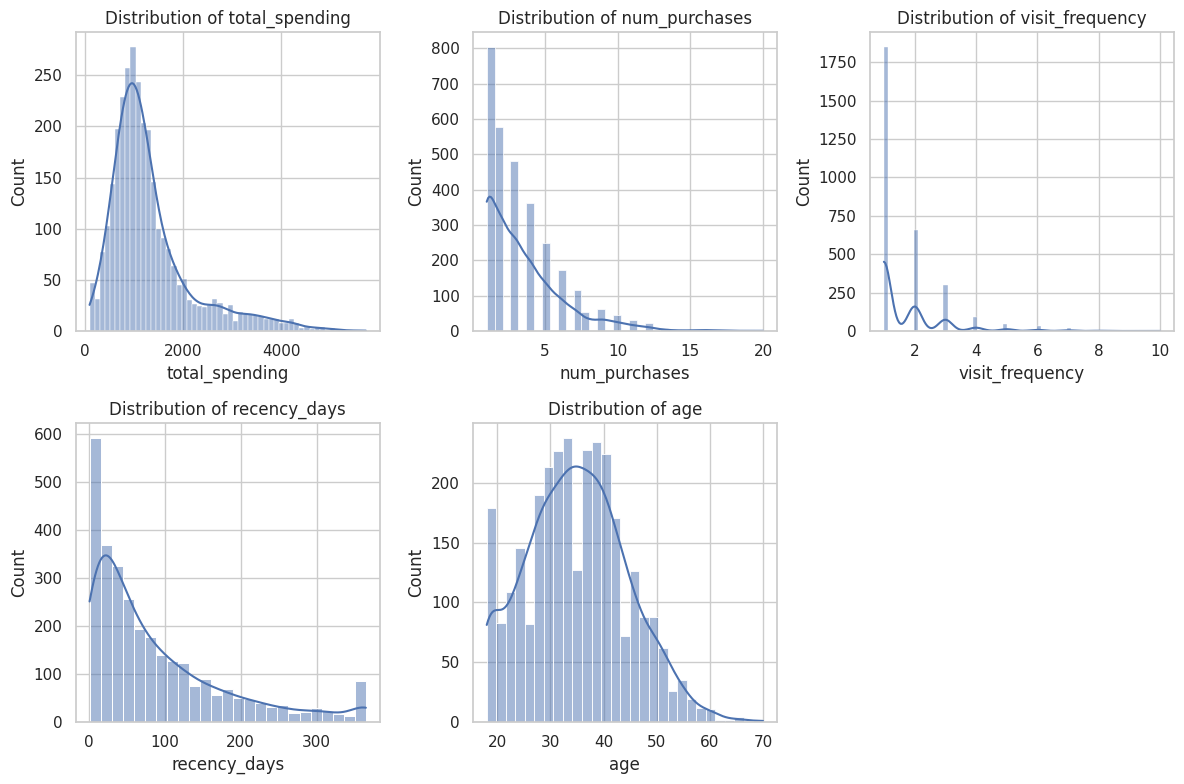

In [4]:
# 2.3 Distributions of key numeric features
# -----------------------------
numeric_cols = ["total_spending", "num_purchases", "visit_frequency", "recency_days", "age"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

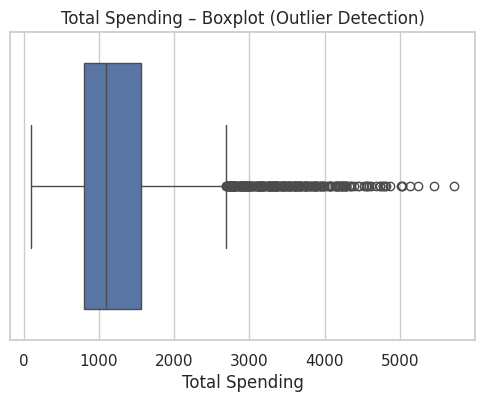

In [5]:
# 2.4 Boxplot for spending (outliers)
# -----------------------------
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["total_spending"])
plt.title("Total Spending – Boxplot (Outlier Detection)")
plt.xlabel("Total Spending")
plt.show()

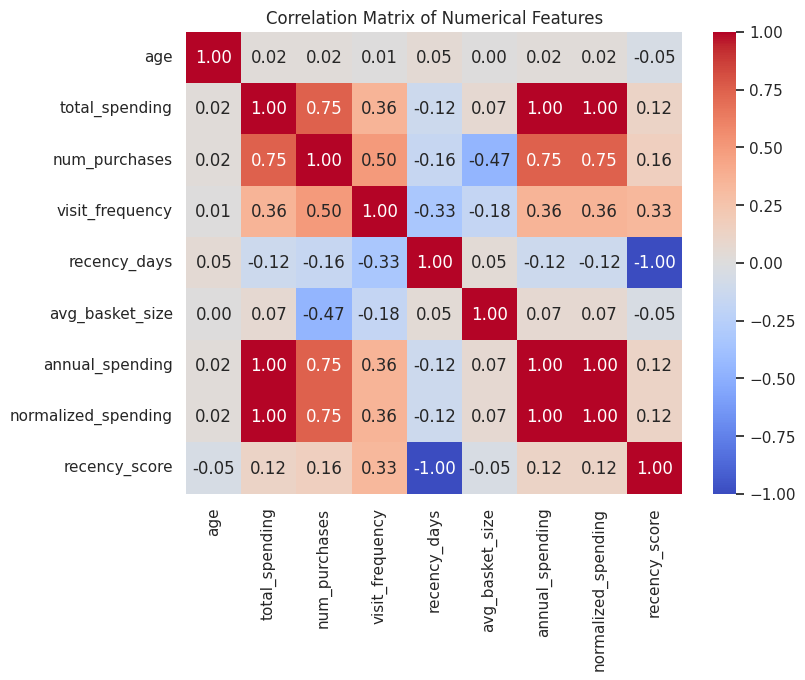

In [6]:
# 2.5 Correlation matrix
# -----------------------------
corr_cols = [
    "age",
    "total_spending",
    "num_purchases",
    "visit_frequency",
    "recency_days",
    "avg_basket_size",
    "annual_spending",
    "normalized_spending",
    "recency_score",
]

corr = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

## Step 3 – Feature Selection & Preprocessing

Before applying K-Means clustering, we need to curate the feature set.
Clustering relies on distance calculations, so "noise" and redundant data can confuse the model.

### 1. Address Multicollinearity
In the raw data, several features measure the exact same thing (e.g., `total_spending` vs `annual_spending`). To prevent the model from overweighting spending, we will drop redundant columns and keep only the core **Behavioral Metrics (RFM)**:
- **Monetary:** `total_spending`, `avg_basket_size`
- **Frequency:** `num_purchases`, `visit_frequency`
- **Recency:** `recency_days`
- **Demographic:** `age`

### 2. Isolate Behavioral Features
We will **exclude** categorical variables (Gender, Country, Category) from the clustering process.
* **Why?** K-Means uses Euclidean distance. Mixing binary data (0/1 from encoding) with continuous data (spending amounts) often dilutes the cluster quality.
* **Plan:** We will cluster based on **behavior** first, and then use the categorical data later to profile the segments.

### 3. Scale features using StandardScaler
K-Means is sensitive to the scale of data. Spending ranges in the thousands, while frequency is single digits. We apply **StandardScaler** to ensure all features contribute equally to the distance calculations.

In [10]:
# STEP 3: Feature Engineering & Preprocessing (REVISED)

# 1. Select ONLY behavioral features for clustering
# We drop 'annual_spending' and 'normalized_spending' to avoid duplication
cluster_features = [
    "total_spending",   # Monetary
    "num_purchases",    # Frequency
    "visit_frequency",  # Frequency
    "recency_days",     # Recency
    "avg_basket_size",  # Monetary/Behavior
    "age"               # Demographic (optional, but often useful)
]

# We do NOT include Country/Gender/Category in the clustering matrix (X).
# We will use them later to describe the clusters.

print("Selected Features for Clustering:", cluster_features)

# 2. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

print("Scaled Matrix Shape:", X_scaled.shape)

Selected Features for Clustering: ['total_spending', 'num_purchases', 'visit_frequency', 'recency_days', 'avg_basket_size', 'age']
Scaled Matrix Shape: (3000, 6)


## Step 4 – K-Means Clustering

In this step, we apply the K-Means algorithm to segment the customers based on the scaled behavioral data.

### Choosing the number of clusters (k)
Finding the "right" number of clusters is a balance between mathematical precision and business utility. We use two methods:

1.  **Elbow Method:** We look for the point where the inertia (error) begins to flatten out.
2.  **Silhouette Score:** We measure how distinct the clusters are from one another.

### The "Business vs. Math" Trade-off
Real-world customer behavior is rarely composed of distinct "islands" of data; it is usually a continuous spectrum (a gradient).
* **Strict Math:** Might suggest $k=2$ (splitting only High vs. Low value).
* **Business Utility:** We often choose a higher $k$ (e.g., 4 or 5) even if the score is slightly lower, because it allows us to identify specific actionable groups like "Loyalists" or "Churn Risk" that a simple 2-way split would miss.

### Final Clustering
We will fit the model with our chosen $k$ and assign labels to the dataset for analysis.

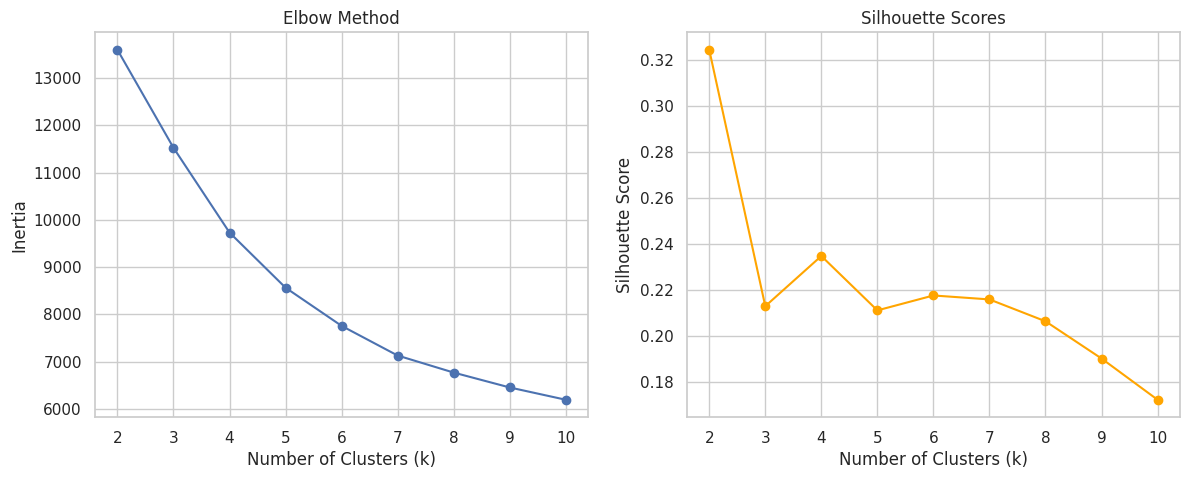

k=2: 0.325
k=3: 0.213
k=4: 0.235
k=5: 0.211
k=6: 0.218
k=7: 0.216
k=8: 0.206
k=9: 0.190
k=10: 0.172


In [11]:
# STEP 4: Elbow Method & Silhouette Analysis

inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)
    score = silhouette_score(X_scaled, km.labels_)
    silhouette_scores.append(score)

# Plotting Side-by-Side
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Plot
ax[0].plot(K_range, inertia, marker='o')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow Method')

# Silhouette Plot
ax[1].plot(K_range, silhouette_scores, marker='o', color='orange')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Scores')

plt.show()

# Print scores
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

In [12]:
# Apply the best K
best_k = 4 # Change this based on your new graphs
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# ANALYSIS: Group by Cluster
# numeric mean
numeric_summary = df.groupby('cluster')[cluster_features].mean()

# See top categories per cluster
category_summary = df.groupby('cluster')['favorite_category'].agg(pd.Series.mode)

print("Cluster Centers (Averages):")
display(numeric_summary)
print("\nTop Category by Cluster:")
display(category_summary)

Cluster Centers (Averages):


,total_spending,num_purchases,visit_frequency,recency_days,avg_basket_size,age
cluster,,,,,,
0,1195.583239,1.248239,1.355634,73.248239,986.979261,34.285211
1,2899.331628,8.578811,3.315245,45.144703,355.990026,35.312661
2,1070.573920,2.732000,1.092000,251.328000,454.303400,37.142000
3,1061.177521,3.214239,1.565049,52.704854,359.724201,34.445307



Top Category by Cluster:


,favorite_category
cluster,
0,Makeup
1,Handbags
2,Makeup
3,Makeup


## Step 5 – Visualizing Customer Segments (k = 4)

With the optimal number of clusters selected (k = 4 based on the silhouette score), we now visualize the clusters to understand their structure.

### Visualizations:
1. **PCA 2D Scatter Plot**  
   Reduces all features to two principal components so we can see how clusters are separated.

2. **Spending vs Frequency Plot**  
   Shows how customer spending relates to shopping behavior.

3. **Cluster Heatmap**  
   Displays the average characteristics of each segment (spending, frequency, etc.).

These visualizations help explain each segment clearly and support the final business insights.


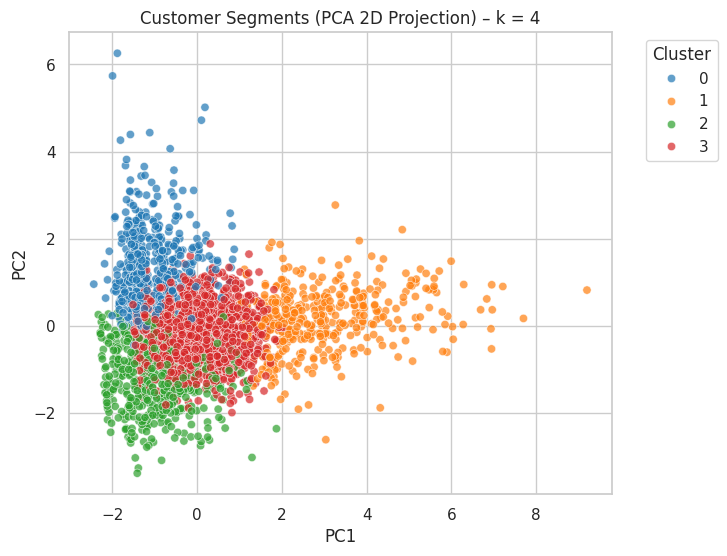

In [13]:
# STEP 5.1: PCA Visualization (k = 4)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["pc1"] = X_pca[:, 0]
df["pc2"] = X_pca[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x="pc1",
    y="pc2",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("Customer Segments (PCA 2D Projection) – k = 4")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


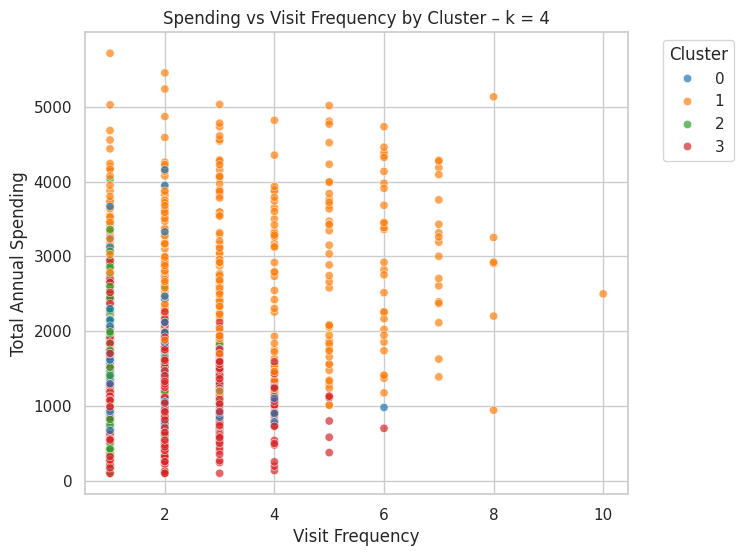

In [14]:
# STEP 5.2: Spending vs Frequency (k = 4)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x="visit_frequency",
    y="total_spending",
    hue="cluster",
    palette="tab10",
    alpha=0.7
)
plt.title("Spending vs Visit Frequency by Cluster – k = 4")
plt.xlabel("Visit Frequency")
plt.ylabel("Total Annual Spending")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


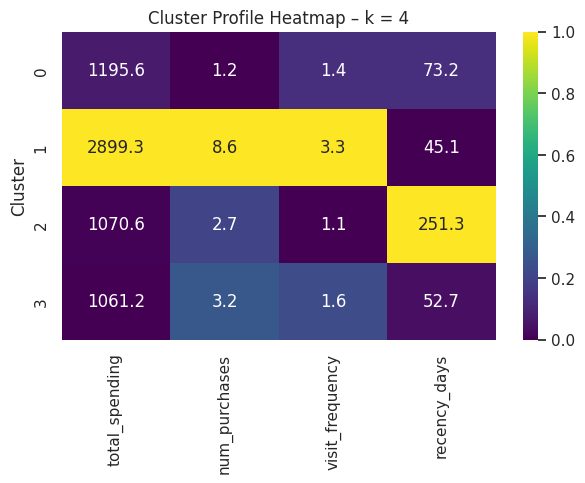

,total_spending,num_purchases,visit_frequency,recency_days
cluster,,,,
0,1195.6,1.2,1.4,73.2
1,2899.3,8.6,3.3,45.1
2,1070.6,2.7,1.1,251.3
3,1061.2,3.2,1.6,52.7


In [15]:
# STEP 5.3: Cluster Heatmap (k = 4)

cluster_profile = (
    df.groupby("cluster")[
        ["total_spending", "num_purchases", "visit_frequency", "recency_days"]
    ]
    .mean()
    .round(1)
)

# Normalize for heatmap
cluster_profile_scaled = (
    (cluster_profile - cluster_profile.min()) /
    (cluster_profile.max() - cluster_profile.min())
)

plt.figure(figsize=(7, 4))
sns.heatmap(
    cluster_profile_scaled,
    annot=cluster_profile,
    fmt=".1f",
    cmap="viridis"
)
plt.title("Cluster Profile Heatmap – k = 4")
plt.ylabel("Cluster")
plt.show()

cluster_profile


### Step 6 – Business Insights for Customer Segments

After clustering customers into four segments (k = 4), we analyze each cluster to understand:

- Who the customers are  
- How much they spend  
- How often they buy  
- How recent their activity is  
- Which categories and countries dominate  
- Which segments contribute the most revenue  

These insights help luxury retail brands identify:

- VIP high-value customers  
- Frequent beauty or skincare buyers  
- Moderate spenders with potential  
- Low-frequency or price-sensitive shoppers  

This business interpretation is crucial for real-world applications such as targeted marketing, personalized recommendations, loyalty programs, and revenue optimization.


In [16]:
# STEP 6: Business Insights for k = 4

results = []

total_revenue = df["total_spending"].sum()

for c in sorted(df["cluster"].unique()):
    seg = df[df["cluster"] == c]
    size = len(seg)
    share = size / len(df)

    avg_spend = seg["total_spending"].mean()
    avg_freq = seg["visit_frequency"].mean()
    avg_recency = seg["recency_days"].mean()
    revenue = seg["total_spending"].sum()
    revenue_share = revenue / total_revenue

    top_country = seg["country"].value_counts().idxmax()
    top_gender = seg["gender"].value_counts().idxmax()
    top_category = seg["favorite_category"].value_counts().idxmax()

    summary = {
        "cluster": c,
        "customers": size,
        "customer_share": share,
        "avg_spending": avg_spend,
        "avg_visit_frequency": avg_freq,
        "avg_recency_days": avg_recency,
        "revenue": revenue,
        "revenue_share": revenue_share,
        "top_country": top_country,
        "top_gender": top_gender,
        "top_category": top_category,
    }
    results.append(summary)

insights_df = pd.DataFrame(results)
insights_df.sort_values("revenue", ascending=False)


,cluster,customers,customer_share,avg_spending,avg_visit_frequency,avg_recency_days,revenue,revenue_share,top_country,top_gender,top_category
3,3,1545,0.515000,1061.177521,1.565049,52.704854,1639519.27,0.412360,United Arab Emirates,Female,Makeup
1,1,387,0.129000,2899.331628,3.315245,45.144703,1122041.34,0.282208,United Arab Emirates,Female,Handbags
0,0,568,0.189333,1195.583239,1.355634,73.248239,679091.28,0.170800,United Arab Emirates,Female,Makeup
2,2,500,0.166667,1070.573920,1.092000,251.328000,535286.96,0.134632,Saudi Arabia,Female,Makeup


In [17]:
# STEP 6.2: Textual Summary for Each Cluster

for row in insights_df.itertuples():
    print(
        f"\n=== Cluster {row.cluster} ==="
        f"\nSize: {row.customers} customers ({row.customer_share:.1%})"
        f"\nAvg Spending: ${row.avg_spending:,.0f}"
        f"\nVisit Frequency: {row.avg_visit_frequency:.1f} per month"
        f"\nRecency: {row.avg_recency_days:.0f} days"
        f"\nTop Country: {row.top_country}"
        f"\nTop Gender: {row.top_gender}"
        f"\nTop Category: {row.top_category}"
        f"\nRevenue Contribution: {row.revenue_share:.1%}"
    )



=== Cluster 0 ===
Size: 568 customers (18.9%)
Avg Spending: $1,196
Visit Frequency: 1.4 per month
Recency: 73 days
Top Country: United Arab Emirates
Top Gender: Female
Top Category: Makeup
Revenue Contribution: 17.1%

=== Cluster 1 ===
Size: 387 customers (12.9%)
Avg Spending: $2,899
Visit Frequency: 3.3 per month
Recency: 45 days
Top Country: United Arab Emirates
Top Gender: Female
Top Category: Handbags
Revenue Contribution: 28.2%

=== Cluster 2 ===
Size: 500 customers (16.7%)
Avg Spending: $1,071
Visit Frequency: 1.1 per month
Recency: 251 days
Top Country: Saudi Arabia
Top Gender: Female
Top Category: Makeup
Revenue Contribution: 13.5%

=== Cluster 3 ===
Size: 1545 customers (51.5%)
Avg Spending: $1,061
Visit Frequency: 1.6 per month
Recency: 53 days
Top Country: United Arab Emirates
Top Gender: Female
Top Category: Makeup
Revenue Contribution: 41.2%
